## Keras + RNN(GRU) to handle passbands as timeseries
Most of the kernels I saw here were not treating passbands as timeseries, but calculating meta feature such as mean/min/max of flux.
Here I'm making simple kernel which uses all the timeseries data as input of RNN(GRU).
I hope this helps your exploration. I'd appreciate your insights and feedback.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import time
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import GRU, Dense, Activation, Dropout, CuDNNGRU, concatenate, Input
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
ROOT_PATH = "/media/hayk/ecf060ce-bc56-4885-9176-43d514db6c66/pac"

import os
print(os.listdir(ROOT_PATH))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['test_set.csv.zip', 'test_set_sample.csv', 'test_set_metadata.csv', 'test_set_metadata.csv.zip', 'test_set_sample.csv.zip', 'training_set_metadata.csv', 'data_note.pdf', 'training_set.csv', 'fake030.csv', 'fake010.csv', 'data_note.pdf.zip', 'training_set.csv.zip', 'test_set.csv']


In [2]:
train = pd.read_csv(os.path.join(ROOT_PATH, 'training_set.csv'))
train.head()

object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1

## Standardize
Standardize input before we process data. NN likes properly scaled data.

In [3]:
ss = StandardScaler()
train[['mjd', 'flux', 'flux_err']] = ss.fit_transform(train[['mjd', 'flux', 'flux_err']])
print(train.shape)
print(train.object_id.unique().shape)
train.head()

(1421705, 6)
(7848,)


object_id       mjd  passband      flux  flux_err  detected
0        615 -1.386583         2 -0.154566 -0.005732         1
1        615 -1.386558         1 -0.228287 -0.005226         1
2        615 -1.386534         3 -0.134638 -0.005686         1
3        615 -1.386512         4 -0.112274 -0.003695         1
4        615 -1.380167         2 -0.191762 -0.005623         1

## Magical transformation
As you see above, train data can be grouped by object_id, passband, list of [flux] order by mjd.

Meaning 1 train input row would be<br>
``
object_id = 615, passband=1, flux0 = 0.228287, flux1 = xxx, ... flux72 = xxx
``

Similary we can have similar row for flux_err.<br>
``
object_id = 615, passband=1, flux_err0 = 0.0.005226, flux_err = xxx, ... flux_err = xxx
``

The following methods do the transformation!

In [4]:
def get_timeseries_by_column_name(train, passband, column_name):
    train_passband = train[train.passband == passband]
    ## This is where magic happens
    train_column_timeseries = train_passband.groupby(['object_id', 'passband'])[column_name].apply(lambda df: df.reset_index(drop=True)).unstack()
    train_column_timeseries.fillna(0, inplace=True)
    train_column_timeseries  = train_column_timeseries.reset_index()
    train_column_timeseries['feature_id'] = column_name
    return train_column_timeseries

def get_timeseries(train, passband):
    df = pd.concat([get_timeseries_by_column_name(train, passband, column_name) for column_name in ['mjd', 'flux', 'flux_err', 'detected']])
    df = df.sort_values(['object_id', 'passband'])
    return df

In [5]:
# One example for flux where passband=0
get_timeseries_by_column_name(train, passband=0, column_name='flux').head()

object_id  passband         0         1         2         3         4  \
0        615         0 -0.004834  0.003983 -0.009529 -0.024474 -0.037464   
1        713         0 -0.004728 -0.005569 -0.005976 -0.006797 -0.006067   
2        730         0 -0.007336 -0.005783 -0.007306 -0.006386 -0.005088   
3        745         0 -0.006555 -0.006034 -0.006587 -0.007031 -0.005994   
4       1124         0 -0.006798 -0.005864 -0.007726 -0.006574 -0.008547   

          5         6         7     ...            63        64        65  \
0 -0.025293 -0.033123 -0.033169     ...      0.000000  0.000000  0.000000   
1 -0.005670 -0.005371 -0.006339     ...     -0.008738 -0.009578 -0.010021   
2 -0.006750 -0.007100 -0.006589     ...     -0.006982 -0.006977 -0.006590   
3 -0.005709 -0.006772 -0.006965     ...     -0.007041 -0.007089 -0.006828   
4 -0.006898 -0.006172 -0.006554     ...      0.000000  0.000000  0.000000   

         66        67        68        69        70        71  feature_id  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000        flux  
1 -0.009460 -0.009639 -0.009998 -0.009054  0.000000  0.000000        flux  
2 -0.007582 -0.006129 -0.006585 -0.006980 -0.006906 -0.006295        flux  
3 -0.006683 -0.006480 -0.007158 -0.007173 -0.006939 -0.006840        flux  
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000        flux  

[5 rows x 75 columns]

In [6]:
# for each passband we get input rows for mjd, flux, flux_err, detected
train_list = []
for passband in range(0, 6):
    train_passband =  get_timeseries(train, passband=passband)
    train_list.append(train_passband)
    print("train_list[%d]" % passband, train_list[passband].shape)

train_list[0] (31392, 75)
train_list[1] (31392, 61)
train_list[2] (31392, 61)
train_list[3] (31392, 61)
train_list[4] (31392, 61)
train_list[5] (31392, 60)


As you can see the shapes above, each passband __may have__ different length of time series. eg) passband0 has len = 75, but passband1 = 61.

## Transform for RNN input
 Input to RNN is (batch_size, timesteps, input_dim).
 - batch_size is batch_size :)
 - timesteps is 75 for passband0,
 - input_dim is number of feature the timeseries has, here we have 4 ['mjd', 'flux', 'flux_err', 'detected'].

In [7]:
num_features = len(['mjd', 'flux', 'flux_err', 'detected'])
drop_features= [ "feature_id", "object_id", "passband"]
X_train_list = []
for passband in range(0, 6):
    num_columns = len(train_list[passband].columns) - len(drop_features)
    print("num_columns[%d]:" % passband, num_columns)
    X_train_list.append(train_list[passband].drop(drop_features, axis=1).values.reshape(-1, num_features, num_columns).transpose(0, 2, 1))
    print("X_train_list[%d].shape:" % passband, X_train_list[passband].shape)

num_columns[0]: 72
X_train_list[0].shape: (7848, 72, 4)
num_columns[1]: 58
X_train_list[1].shape: (7848, 58, 4)
num_columns[2]: 58
X_train_list[2].shape: (7848, 58, 4)
num_columns[3]: 58
X_train_list[3].shape: (7848, 58, 4)
num_columns[4]: 58
X_train_list[4].shape: (7848, 58, 4)
num_columns[5]: 57
X_train_list[5].shape: (7848, 57, 4)


## Merge target value from metadata

In [8]:
meta_train = pd.read_csv(os.path.join(ROOT_PATH, 'training_set_metadata.csv'))
meta_train.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  
0         0.0000          0.0000              0.0000      NaN  0.017      92  
1         1.8181          1.6267              0.2552  45.4063  0.007      88  
2         0.2320          0.2262              0.0157  40.2561  0.021      42  
3         0.3037          0.2813              1.1523  40.7951  0.007      90  
4         0.1934          0.2415              0.0176  40.4166  0.024      90

In [9]:
# List all classes
classes = sorted(meta_train.target.unique())
classes

[6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]

In [10]:
class_map = dict()
for i,val in enumerate(classes):
    class_map[val] = i
class_map

{6: 0,
 15: 1,
 16: 2,
 42: 3,
 52: 4,
 53: 5,
 62: 6,
 64: 7,
 65: 8,
 67: 9,
 88: 10,
 90: 11,
 92: 12,
 95: 13}

In [11]:
# We only need target for earch object_id, so using feature_id=='flux'
merged_train = train_list[0][train_list[0].feature_id == 'flux'].merge(meta_train, on='object_id', how='left')
merged_train = merged_train.drop(['ra',	'decl',	'gal_l',	'gal_b',	'ddf',	'hostgal_specz',	'hostgal_photoz',	'hostgal_photoz_err',	'distmod',	'mwebv'], axis=1)
merged_train.head()

object_id  passband         0         1         2         3         4  \
0        615         0 -0.004834  0.003983 -0.009529 -0.024474 -0.037464   
1        713         0 -0.004728 -0.005569 -0.005976 -0.006797 -0.006067   
2        730         0 -0.007336 -0.005783 -0.007306 -0.006386 -0.005088   
3        745         0 -0.006555 -0.006034 -0.006587 -0.007031 -0.005994   
4       1124         0 -0.006798 -0.005864 -0.007726 -0.006574 -0.008547   

          5         6         7   ...          64        65        66  \
0 -0.025293 -0.033123 -0.033169   ...    0.000000  0.000000  0.000000   
1 -0.005670 -0.005371 -0.006339   ...   -0.009578 -0.010021 -0.009460   
2 -0.006750 -0.007100 -0.006589   ...   -0.006977 -0.006590 -0.007582   
3 -0.005709 -0.006772 -0.006965   ...   -0.007089 -0.006828 -0.006683   
4 -0.006898 -0.006172 -0.006554   ...    0.000000  0.000000  0.000000   

         67        68        69        70        71  feature_id  target  
0  0.000000  0.000000  0.000000  0.000000  0.000000        flux      92  
1 -0.009639 -0.009998 -0.009054  0.000000  0.000000        flux      88  
2 -0.006129 -0.006585 -0.006980 -0.006906 -0.006295        flux      42  
3 -0.006480 -0.007158 -0.007173 -0.006939 -0.006840        flux      90  
4  0.000000  0.000000  0.000000  0.000000  0.000000        flux      90  

[5 rows x 76 columns]

In [12]:
targets = merged_train.target
target_map = np.zeros((targets.shape[0],))
target_map = np.array([class_map[val] for val in targets])
Y = to_categorical(target_map)
Y.shape

(7848, 14)

In [13]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

# 
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()


## RNN(GRU) begins here :)
Note that
- I'm using Keras functional API which supports multples inputs.
- I intentionally __chose small values for GRU parameters and epochs for demo purpose__, as GRU is slow to train.

In [14]:
n_classes = len(classes)

def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

def build_model():
    def basic_layer(input_):
        output = GRU(64,
                     kernel_initializer=weight_variable,
                     dropout=0.5,
                     recurrent_dropout=0.5,
                     return_sequences=True)(input_)
        output = Dropout(0.5)(output)
        output = GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(output)
        output = GRU(16, dropout=0.5, recurrent_dropout=0.5)(output)
        output = Dense(32)(output)
        return output
    
    # Keras functional API supports multiple inputs!
    input0 = Input(shape=(None, num_features), dtype='float32', name='passband0')
    input1 = Input(shape=(None, num_features), dtype='float32', name='passband1')
    input2 = Input(shape=(None, num_features), dtype='float32', name='passband2')
    input3 = Input(shape=(None, num_features), dtype='float32', name='passband3')
    input4 = Input(shape=(None, num_features), dtype='float32', name='passband4')
    input5 = Input(shape=(None, num_features), dtype='float32', name='passband5')
    
    merged_output = concatenate([basic_layer(input0),basic_layer(input1),basic_layer(input2),basic_layer(input3),basic_layer(input4),basic_layer(input5)])
    merged_output = Dense(64)(merged_output)
    final_output = Dense(len(classes), activation='softmax')(merged_output)
    return Model(inputs=[input0, input1, input2, input3, input4, input5], outputs=[final_output])

In [15]:
y_count = Counter(target_map)
wtable = np.zeros((len(classes),))
for i in range(len(classes)):
    wtable[i] = y_count[i] / target_map.shape[0]

In [16]:
y_categorical.shape

NameError: name 'y_categorical' is not defined

Train on 6274 samples, validate on 1574 samples
Epoch 1/10
6274/6274 [==============================] - 31s 5ms/step - loss: 2.6355 - acc: 0.0410 - val_loss: 2.6388 - val_acc: 0.0127
Epoch 2/10
6274/6274 [==============================] - 17s 3ms/step - loss: 2.6227 - acc: 0.0550 - val_loss: 2.6192 - val_acc: 0.0241
Epoch 3/10
6274/6274 [==============================] - 18s 3ms/step - loss: 2.6070 - acc: 0.0856 - val_loss: 2.5987 - val_acc: 0.0909
Epoch 4/10
6274/6274 [==============================] - 19s 3ms/step - loss: 2.6076 - acc: 0.0783 - val_loss: 2.5879 - val_acc: 0.0756
Epoch 5/10
6274/6274 [==============================] - 19s 3ms/step - loss: 2.6027 - acc: 0.0773 - val_loss: 2.5893 - val_acc: 0.0311
Epoch 6/10
6274/6274 [==============================] - 20s 3ms/step - loss: 2.5942 - acc: 0.0687 - val_loss: 2.5775 - val_acc: 0.1417
Epoch 7/10
6274/6274 [==============================] - 20s 3ms/step - loss: 2.5895 - acc: 0.0775 - val_loss: 2.5578 - val_acc: 0.0305
Epoch 8

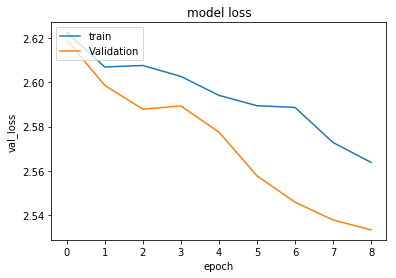

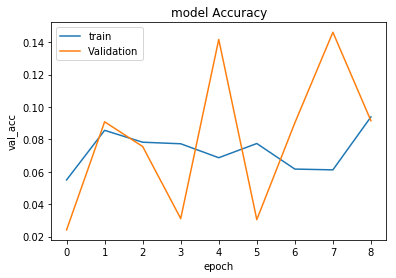

Loading Best Model
2.5355322418625774
Train on 6276 samples, validate on 1572 samples
Epoch 1/10
6276/6276 [==============================] - 34s 5ms/step - loss: 2.6362 - acc: 0.0430 - val_loss: 2.6358 - val_acc: 0.0744


KeyboardInterrupt: 

In [17]:
batch_size = 512
y_map = target_map
y_categorical = Y
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
start = time.time()
clfs = []
oof_preds = np.zeros((len(X_train_list[0]), len(classes)))
epochs = 10 #5000

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint('./keras.model',monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    X0 = X_train_list[0]
    X1 = X_train_list[1]
    X2 = X_train_list[2]
    X3 = X_train_list[3]
    X4 = X_train_list[4]
    X5 = X_train_list[5]
    x_train0, x_train1, x_train2, x_train3, x_train4, x_train5, y_train = X0[trn_], X1[trn_], X2[trn_], X3[trn_], X4[trn_], X5[trn_], y_categorical[trn_]
    x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5, y_valid = X0[val_], X1[val_], X2[val_], X3[val_], X4[val_], X5[val_], y_categorical[val_]
    
    model = build_model()    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)#
    early_stopping = EarlyStopping(monitor='loss', patience=30, verbose=1)
    model.compile(loss=mywloss, optimizer=optimizer, metrics=['accuracy'])
    history = model.fit([x_train0, x_train1, x_train2, x_train3, x_train4, x_train5], y_train,
                    validation_data=[[x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5], y_valid], 
                    epochs=epochs,
                        batch_size=batch_size,
                    shuffle=True,verbose=1,callbacks=[checkPoint, early_stopping])      
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict([x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5],batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict([x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5],batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

elapsed_time = time.time() - start
print("elapsed_time:", elapsed_time)

## Ideas for improvement
- Add one more input for metadata.
- Derive some features as timeseries and feed into the RNN?